# Explore the Inference Pipeline

In [1]:
import torch
import json
import os
import warnings
from datetime import datetime
import matplotlib.pyplot as plt
import json
import numpy as np
import pandas as pd
import torch
import torchvision.transforms as transforms
from PIL import Image, ImageDraw, ImageFont

from utils.custom_models import load_models
from utils.inference_scripts import classify_species, classify_order, flatbug, classify_box

In [2]:
regional_category_map_path='./models/03_uk_data_category_map.json'

# load the json
with open(regional_category_map_path) as f:
    regional_category_map = json.load(f)

regional_category_map

{'Geometra papilionaria': 0,
 'Adela cuprella': 1,
 'Scopula immorata': 2,
 'Archanara dissoluta': 3,
 'Hellinsia carphodactyla': 4,
 'Thyridopteryx ephemeraeformis': 5,
 'Depressaria ultimella': 6,
 'Symmetrischema pallidochrella': 7,
 'Lacanobia w-latinum': 8,
 'Ennomos quercaria': 9,
 'Pammene aurita': 10,
 'Papestra biren': 11,
 'Anarsia innoxiella': 12,
 'Argyresthia conjugella': 13,
 'Spargania luctuata': 14,
 'Ancylis subarcuana': 15,
 'Epinotia tedella': 16,
 'Autographa bimaculata': 17,
 'Cydia interscindana': 18,
 'Bactra venosana': 19,
 'Tetramoera langmaidi': 20,
 'Coleophora adjunctella': 21,
 'Coleophora albidella': 22,
 'Leucania loreyi': 23,
 'Anticlea badiata': 24,
 'Euzophera bigella': 25,
 'Spodoptera eridania': 26,
 'Endothenia pullana': 27,
 'Ennomos fuscantaria': 28,
 'Panemeria tenebrata': 29,
 'Grapholita funebrana': 30,
 'Euhyponomeuta stannella': 31,
 'Coleophora paripennella': 32,
 'Phaulernis fulviguttella': 33,
 'Argyresthia dilectella': 34,
 'Ennomos alnia

In [3]:
# check if they go in order
list(regional_category_map.values()) == list(range(len(regional_category_map)))

True

In [4]:
# test the labeling is being indexed correctly
index_to_label = {index: label for label, index in regional_category_map.items()}

index_to_label

{0: 'Geometra papilionaria',
 1: 'Adela cuprella',
 2: 'Scopula immorata',
 3: 'Archanara dissoluta',
 4: 'Hellinsia carphodactyla',
 5: 'Thyridopteryx ephemeraeformis',
 6: 'Depressaria ultimella',
 7: 'Symmetrischema pallidochrella',
 8: 'Lacanobia w-latinum',
 9: 'Ennomos quercaria',
 10: 'Pammene aurita',
 11: 'Papestra biren',
 12: 'Anarsia innoxiella',
 13: 'Argyresthia conjugella',
 14: 'Spargania luctuata',
 15: 'Ancylis subarcuana',
 16: 'Epinotia tedella',
 17: 'Autographa bimaculata',
 18: 'Cydia interscindana',
 19: 'Bactra venosana',
 20: 'Tetramoera langmaidi',
 21: 'Coleophora adjunctella',
 22: 'Coleophora albidella',
 23: 'Leucania loreyi',
 24: 'Anticlea badiata',
 25: 'Euzophera bigella',
 26: 'Spodoptera eridania',
 27: 'Endothenia pullana',
 28: 'Ennomos fuscantaria',
 29: 'Panemeria tenebrata',
 30: 'Grapholita funebrana',
 31: 'Euhyponomeuta stannella',
 32: 'Coleophora paripennella',
 33: 'Phaulernis fulviguttella',
 34: 'Argyresthia dilectella',
 35: 'Ennomos a

In [5]:
# now check these match
assert(list(index_to_label.keys()) == list(range(len(regional_category_map))))
assert(list(index_to_label.values()) == list(regional_category_map.keys()))
assert(list(index_to_label.keys()) == list(regional_category_map.values()))

In [6]:
# heavily populated image
image_path1 = '/home/users/katriona/amber-inferences/data/uk/downloaded_images/most_populated/20240624233310-snapshot.jpg'

# image with blur
image_path2 = '/home/users/katriona/amber-inferences/data/uk/downloaded_images/20240626230030-snapshot.jpg'

# nice obvious moth
image_path3 = '/home/users/katriona/amber-inferences/data/uk/downloaded_images/20240803003019-snapshot.jpg'

image_path = image_path1

In [7]:
bucket_name = 'gbr'
flatbug_model_path='./models/flat_bug_M.pt'
binary_model_path='./models/moth-nonmoth-effv2b3_20220506_061527_30.pth'
order_model_path='./models/dhc_best_128.pth'
order_labels_path='./models/thresholdsTestTrain.csv'
regional_model_path='./models/turing-uk_v03_resnet50_2024-05-13-10-03_state.pt'
regional_category_map_path='./models/03_uk_data_category_map.json'
localisation_model_path = '/home/users/katriona/amber-inferences/models/v1_localizmodel_2021-08-17-12-06.pt'
order_data_thresholds=image_path,
proc_device=torch.device("cuda:0")
csv_file ='./examples/gb_examples.csv'
save_crops=True
box_threshold=0.995
top_n=5

In [8]:
models = load_models(
        proc_device,
        binary_model_path,
        order_model_path,
        order_labels_path,
        regional_model_path,
        regional_category_map_path,
        flatbug_model_path,
        localisation_model_path,
    )

YOLOv8m-seg summary (fused): 263 layers, 24,586,035 parameters, 0 gradients, 98.7 GFLOPs
passed


In [9]:
transform_species = transforms.Compose(
        [
            transforms.Resize((300, 300)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
        ]
    )

In [10]:
image_dt = os.path.basename(image_path)

if image_dt.startswith('20'):
    image_dt = image_dt.split("-")[0]
else:
    image_dt = image_dt.split("-")[1]
image_dt = datetime.strptime(image_dt, "%Y%m%d%H%M%S%f")
image_dt = datetime.strftime(image_dt, "%Y-%m-%d %H:%M:%S")

current_dt = datetime.now()
current_dt = datetime.strftime(current_dt, "%Y-%m-%d %H:%M:%S")

print(image_dt)

2024-06-24 23:33:01


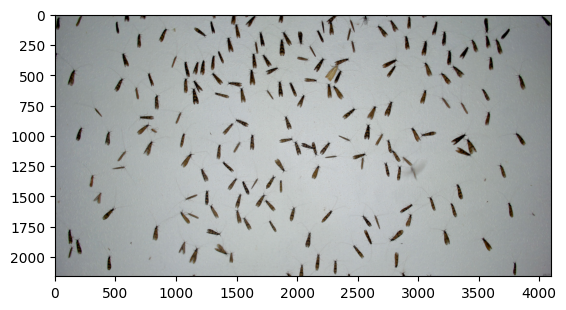

In [11]:
try:
    image = Image.open(image_path).convert("RGB")

    # print the image
    plt.imshow(image)
except Exception as e:
    print(f"Error opening image {image_path}: {e}")



In [12]:
original_image = image.copy()
original_width, original_height = image.size

Plot the flatbug crops and the predictions of the model.

# Example with Flatbug

In [13]:
flatbug_outputs = flatbug(image_path, models['flatbug_model'])

In [16]:
# for each detection
image2 = image.copy()

for i in range(len(flatbug_outputs["boxes"])):
    crop_status = "crop " + str(i)

    x_min, y_min, x_max, y_max = flatbug_outputs["boxes"][i]

    box_score = flatbug_outputs["scores"][i]
    box_label = flatbug_outputs["labels"][i]

    x_min = x_min #* original_width / 300)
    y_min = y_min #* original_height / 300)
    x_max = x_max #* original_width / 300)
    y_max = y_max #* original_height / 300)

    # Crop the detected region and perform classification
    cropped_image = original_image.crop((x_min, y_min, x_max, y_max))
    cropped_tensor = transform_species(cropped_image).unsqueeze(0).to(proc_device)

    class_name, class_confidence = classify_box(cropped_tensor, models['classification_model'])
    order_name, order_confidence = classify_order(
        cropped_tensor, models['order_model'], models['order_model_labels'], models['order_model_thresholds']
    )



    if (class_name == "moth") and ('Lepidoptera' not in order_name):
        col = 'orange'
    elif (class_name != "moth") and ('Lepidoptera' in order_name):
        col = 'purple'
    elif (class_name == "moth") and ('Lepidoptera' in order_name):
            col = 'green'
    else:
        col = 'red'


    # annotate the image with bounding boxes
    draw = ImageDraw.Draw(image2)
    draw.rectangle([x_min, y_min, x_max, y_max], outline=col, width=4)

        # Annotate image with bounding box and class
    if (class_name == "moth") or ("Lepidoptera" in order_name):
        species_names, species_confidences = classify_species(
            cropped_tensor, models['species_model'],
            models['species_model_labels'], top_n
        )
        # annotate the name on the image
        draw.text((x_min, y_min-50),
                f"{species_names[0]}: {species_confidences[0]:.2f}",
                fill=col, font=ImageFont.truetype("DejaVuSans.ttf", 50),
                verticalalignment="bottom")

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
plt.imshow(image2)
plt.axis('off')

# add legend
adj=100
shift=-20
plt.text(0, shift, 'red: non-moth, non-Lepidoptera', color='red', size=8)
plt.text(0, -1*adj+shift, 'orange: moth but not Lepidoptera', color='orange', size=8)
plt.text(0, -2*adj+shift, 'purple: Lepidoptera but not moth', color='purple', size=8)
plt.text(0, -3*adj+shift, 'green: moth and Lepidoptera', color='green', size=8)
plt.show()

# Example with Localisation Model

In [19]:
transform_loc = transforms.Compose(
        [
            transforms.Resize((300, 300)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    )

In [20]:
input_tensor = transform_loc(image).unsqueeze(0).to(proc_device)

with torch.no_grad():
    localisation_outputs = models['localisation_model'](input_tensor)

In [ ]:
len(localisation_outputs[0]["boxes"])

In [ ]:
print(len(localisation_outputs[0]["boxes"]))

In [36]:
box_threshold = 0.8

In [ ]:
# for each detection
image3 = image.copy()

for i in range(len(localisation_outputs[0]["boxes"])):
    crop_status = "crop " + str(i)

    x_min, y_min, x_max, y_max = localisation_outputs[0]["boxes"][i]
    box_score = localisation_outputs[0]["scores"].tolist()[i]
    box_label = localisation_outputs[0]["labels"].tolist()[i]

    x_min = int(int(x_min) * original_width / 300)
    y_min = int(int(y_min) * original_height / 300)
    x_max = int(int(x_max) * original_width / 300)
    y_max = int(int(y_max) * original_height / 300)

    if box_score < box_threshold:
                continue

    # Crop the detected region and perform classification
    cropped_image = original_image.crop((x_min, y_min, x_max, y_max))
    cropped_tensor = transform_species(cropped_image).unsqueeze(0).to(proc_device)

    class_name, class_confidence = classify_box(cropped_tensor, models['classification_model'])
    order_name, order_confidence = classify_order(
        cropped_tensor, models['order_model'], models['order_model_labels'], models['order_model_thresholds']
    )

    if (class_name == "moth") and ('Lepidoptera' not in order_name):
        col = 'orange'
    elif (class_name != "moth") and ('Lepidoptera' in order_name):
        col = 'purple'
    elif (class_name == "moth") and ('Lepidoptera' in order_name):
            col = 'green'
    else:
        col = 'red'


    # annotate the image with bounding boxes
    draw = ImageDraw.Draw(image3)
    draw.rectangle([x_min, y_min, x_max, y_max], outline=col, width=4)

        # Annotate image with bounding box and class
    if (class_name == "moth") or ("Lepidoptera" in order_name):
        species_names, species_confidences = classify_species(
            cropped_tensor, models['species_model'],
            models['species_model_labels'], top_n
        )
        # annotate the name on the image
        draw.text((x_min, y_min-50),
                f"{species_names[0]}: {species_confidences[0]:.2f}",
                fill=col, font=ImageFont.truetype("DejaVuSans.ttf", 50),
                verticalalignment="bottom")

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
plt.imshow(image3)
plt.axis('off')

# add legend
adj=100
shift=-20
plt.text(0, shift, 'red: non-moth, non-Lepidoptera', color='red', size=8)
plt.text(0, -1*adj+shift, 'orange: moth but not Lepidoptera', color='orange', size=8)
plt.text(0, -2*adj+shift, 'purple: Lepidoptera but not moth', color='purple', size=8)
plt.text(0, -3*adj+shift, 'green: moth and Lepidoptera', color='green', size=8)
plt.show()

# Lets look side by side

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(10, 15))
ax[1].imshow(image2)
ax[1].axis('off')
ax[0].imshow(image3)
ax[0].axis('off')

# add legend
# adj=100
# shift=-20
# ax[0].text(0, shift, 'red: non-moth, non-Lepidoptera', color='red', size=8)
# ax[0].text(0, -1*adj+shift, 'orange: moth but not Lepidoptera', color='orange', size=8)
# ax[0].text(0, -2*adj+shift, 'purple: Lepidoptera but not moth', color='purple', size=8)
# ax[0].text(0, -3*adj+shift, 'green: moth and Lepidoptera', color='green', size=8)
plt.show()